# Solving ODE systems

Users can declare a system of Ordinary differential Equations, alongside events that might occur during their numerical integration.

An system of ode's is the form dq/dt = F(t, q), q(t0) = q0, where q is an array that represents a system of variables.

It can be declared as follows:

def f(t, q, *args):
    return [dq[0]/dt, dq[1]/dt, ...]

where *args can be any extra parameters inside the ode.

However it is better to declare the ode using symbolic variables, because:
1) It is more intuitive that way
2) The expression will compile down to binary code, and a low level integrator will solve the ode up to ~200 times faster than
a pure python solver would.

## Symbolic declaration

The second order ODE

$$\ddot{x} = \mu (1-x^2)\dot{x} - x$$

can be written as a system of first order ODE's as

$$
\frac{d}{dt}
\begin{bmatrix}
x \\ y
\end{bmatrix}
=
\begin{bmatrix}
y \\ \mu (1-x^2) y - x
\end{bmatrix}
$$


In [ ]:
from odepack import *

t, x, y, mu = variables('t, x, y, mu')

#we declare the event when x=1 during the ode itegration
#If we pass it into the solver, every time it is encountered during an integration,
#it will be accurately determined using the provided tolerance.
ev1 = SymbolicPreciseEvent("X=1 event", x-1, event_tol=1e-20)
ev2 = SymbolicPeriodicEvent("Periodic Event", period=100)


ode_system = OdeSystem([y, mu*(1 - x**2)*y - x], t, [x, y], args=(mu,), events=[ev1, ev2])

## Pythonic declaration

The user can define pure python functions. If they are passed into the low level solver, the integration will usually be faster than the equivalent scipy implementation, because the algorithm is precompiled. However, using the given tools that internally compile all symbolic expressions provides maximum efficiency, as it will be demonstrated below.

In [2]:
def f_py(t, q, mu):
    x, y = q
    #we assume q = [x, y], so q[0] is x, and q[1] = y
    return [y, mu*(1 - x**2)*y - x]

def jac_py(t, q, mu):
    x, y = q
    return [[0, 1], [-2*mu*x*y - 1, mu*(1-x**2)]]

def event_py(t, q, mu):
    return q[0] - 1 #x-1 event -> when x-1 == 0, the event is triggered

ev1_py = PreciseEvent("X=1 event", event_py, event_tol=1e-20)
ev2_py = PeriodicEvent("Periodic Event", period=100)

## Defining an ODE object

In [3]:
#first let's define the fully low level ode object, where all internal functions are compiled to low level code
ode_lowlevel = ode_system.get(t0=0, q0=[1, 2], rtol=1e-13, atol=1e-13, args=(500,), method="BDF")
print("Only the first .get() call takes longer in order to compile all symbolic expressions")

Compiling...
Done
Only the first .get() call takes longer in order to compile all symbolic expressions


In [4]:
'''
Alternatively, the user can retrieve the callable object that wraps the compiled function, and pass it inside
LowLevelODE. This is true for the optional jacobian, and the event objects too. The LowLevelODE internally
determines which objects are pure compiled functions, and retrieves the hidden C-style pointer to use that instead
of the python wrapper. As a result, there is zero performance loss when comparing to a C++ script that solves the same ODE
using the same C++ headers that have been precompiled for this python library.
'''

events_compiled = ode_system.true_compiled_events
rhs_compiled = ode_system.lowlevel_odefunc
jac_compiled = ode_system.lowlevel_jac #jacobian matrix function

ode_test = LowLevelODE(rhs_compiled, t0=0, q0=[1, 2], jac=jac_compiled, rtol=1e-13, atol=1e-13, args=(500,), events = events_compiled, method="BDF")

In [5]:
#now let's define the ode object with pure python functions
ode_pythonic = LowLevelODE(f_py, jac=jac_py, t0=0, q0=[1, 2], rtol=1e-13, atol=1e-13, args=(500,), events=[ev1_py, ev2_py], method="BDF")

## Performing an integration

In [6]:
result_lowlevel = ode_lowlevel.integrate(400)
result_test = ode_test.integrate(400)

In [7]:
result_pythonic = ode_pythonic.integrate(400)

In [8]:
from scipy.integrate import solve_ivp
import time

ti = time.time()
result_scipy = solve_ivp(f_py, (0, 400), [1, 2], jac=jac_py, method="BDF", rtol=1e-13, atol=1e-13, args=(500,))
tf = time.time()

In [9]:
print("Scipy implementation                  :", tf-ti, " s integration time")
print("LowLevelODE with pure python functions:", result_pythonic.runtime, " s integration time")
print("Fully compiled ODE                    :", result_lowlevel.runtime, " s integration time")
print("Fully compiled test ODE               :", result_test.runtime, " s integration time")
print("As expected, the last two cases have the same performanace")
print("Speedup                               : x", (tf-ti)/result_lowlevel.runtime)

Scipy implementation                  : 0.2801034450531006  s integration time
LowLevelODE with pure python functions: 0.026861678  s integration time
Fully compiled ODE                    : 0.001761233  s integration time
Fully compiled test ODE               : 0.001644185  s integration time
As expected, the last two cases have the same performanace
Speedup                               : x 159.03826753933214


In [10]:
result_lowlevel.t.shape, result_scipy.t.shape

((6134,), (6128,))

## Using ODE objects inside custom classes

If the user wants to encapsulate custom functions and logic using the provided methods of the LowLevelODE class,
they can inherit from the class and pass an ode object in its constructor. Then, the returned object (of the custom class) will
hold a perfect copy of the given LowlevelODE object, as follows

In [11]:
import matplotlib.pyplot as plt

class Orbit(LowLevelODE):

    @property
    def x(self):
        return self.q[:, 0]
    
    @property
    def y(self):
        return self.q[:, 1]
    
    def plot_x(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.x)
        ax.set_xlabel("t")
        ax.set_ylabel("x")
        return fig, ax
    
    def plot_y(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.y)
        ax.set_xlabel("t")
        ax.set_ylabel("y")
        return fig, ax
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        return fig, ax
    

orbit = Orbit(ode_lowlevel) #now ode_lowlevel can even be deleted, orbit created a perfect copy out of it
#to test this, see what happens before and after we advance the orbit.

In [12]:
print("Before integrating:")
print("     ode_lowlevel is at t =", ode_lowlevel.t[-1])
print("     orbit is at t =", orbit.t[-1])
orbit.integrate(10000)
print("After integrating:")
print("     ode_lowlevel is still at t =", ode_lowlevel.t[-1])
print("     orbit is at t =", orbit.t[-1])
print("So 'orbit' is completely independent of 'ode_lowlevel', even if it was passed in its constructor. A perfect copy was created.")

Before integrating:
     ode_lowlevel is at t = 400.0
     orbit is at t = 400.0
After integrating:
     ode_lowlevel is still at t = 400.0
     orbit is at t = 10400.0
So 'orbit' is completely independent of 'ode_lowlevel', even if it was passed in its constructor. A perfect copy was created.


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='t', ylabel='x'>)

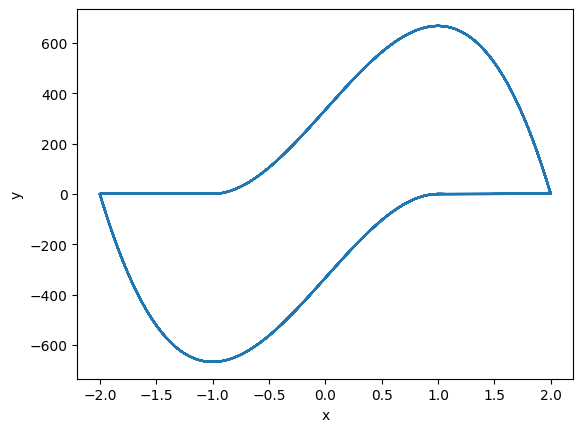

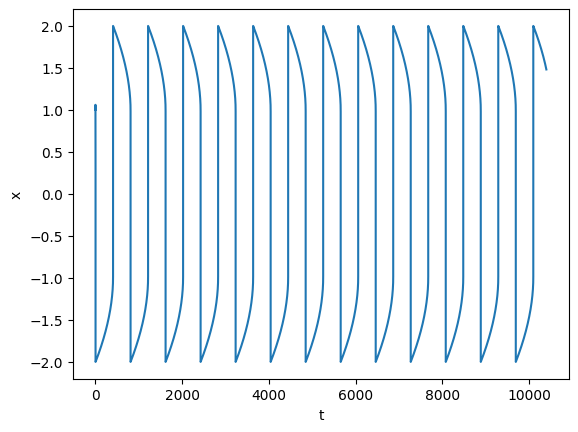

In [13]:
orbit.plot()
orbit.plot_x()

In [14]:
t_event, q_event = orbit.event_data("X=1 event")
q_event[:, 0] #this is the "x" variable at each event instance. As expected, this returns an array filled with approximately x=1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
#We can also retrieve te exact time of each event:
t_event

array([2.04750436e+00, 4.06078894e+02, 8.09773087e+02, 1.21380448e+03,
       1.61749867e+03, 2.02153006e+03, 2.42522425e+03, 2.82925564e+03,
       3.23294984e+03, 3.63698123e+03, 4.04067542e+03, 4.44470681e+03,
       4.84840100e+03, 5.25243239e+03, 5.65612658e+03, 6.06015797e+03,
       6.46385217e+03, 6.86788356e+03, 7.27157775e+03, 7.67560914e+03,
       8.07930333e+03, 8.48333472e+03, 8.88702892e+03, 9.29106031e+03,
       9.69475450e+03, 1.00987859e+04])

In [16]:
#or the indices of the .q and .t arrays that correspond to event
orbit.event_map

{'Periodic Event': array([  5568,   5631,   5731,   6134,  10903,  10966,  11066,  11402,
         16233,  16295,  16392,  16690,  21573,  21634,  21730,  22000,
         26891,  26951,  27043,  27286,  32226,  32285,  32376,  32604,
         37569,  37626,  37714,  37927,  42905,  42963,  43051,  43252,
         48244,  48300,  48386,  48576,  53570,  53624,  53710,  53891,
         58900,  58954,  59034,  59207,  64236,  64290,  64372,  64536,
         69579,  69632,  69710,  69866,  74902,  74954,  75033,  75183,
         80248,  80300,  80375,  80521,  85585,  85635,  85713,  85854,
         90914,  90964,  91036,  91171,  96252,  96302,  96374,  96503,
        101595, 101644, 101718, 101847, 106930, 106979, 107047, 107169,
        112267, 112316, 112385, 112505, 117601, 117650, 117718, 117834,
        122936, 122986, 123055, 123168, 128274, 128325, 128391, 128500,
        133614, 133664, 133733, 133839, 138951, 139008, 139070, 139175],
       dtype=uint64),
 'X=1 event': array([  